In [2]:
import zipfile
import os
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import pingouin as pg

In [3]:
zip_path = os.path.expanduser('~/games.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('cookie_cats.csv') as csv_file:
        df = pd.read_csv(csv_file)

In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [7]:
df.duplicated(subset = 'userid').sum()

np.int64(0)

In [8]:
#исследуем датафрейм

In [9]:
retention_rate_7 = df.groupby('version').retention_7.value_counts().unstack()
retention_rate_7['retention_rate'] = round(retention_rate_7[True] / (retention_rate_7[True] + retention_rate_7[False]) * 100, 2)

In [10]:
retention_rate_7

retention_7,False,True,retention_rate
version,,,
gate_30,36198,8502,19.02
gate_40,37210,8279,18.20


In [11]:
retention_rate_1 = df.groupby('version').retention_1.value_counts().unstack()
retention_rate_1['retention_rate'] = round(retention_rate_1[True] / (retention_rate_1[True] + retention_rate_1[False]) * 100, 2)

In [12]:
retention_rate_1

retention_1,False,True,retention_rate
version,,,
gate_30,24666,20034,44.82
gate_40,25370,20119,44.23


In [13]:
#Выдвигаем гипотезы
#H0: 7-дневный retention rate не отличается между версиями игры gate_30 и gate_40
#H1: 7-дневный retention rate выше у версии игры с gate_30, чем с gate_40
#дискретная величина - хи-квадрат тест 

In [14]:
df_crosstab = pd.crosstab(df.version, df.retention_7)

In [15]:
df_crosstab

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [16]:
st.chi2_contingency(df_crosstab)

Chi2ContingencyResult(statistic=np.float64(9.959086799559167), pvalue=np.float64(0.0016005742679058301), dof=1, expected_freq=array([[36382.90257127,  8317.09742873],
       [37025.09742873,  8463.90257127]]))

In [17]:
(18.20 - 19.02) / 19.02 * 100

-4.31125131440589

In [18]:
#pvalue = 0.001 - отклоняем 0 гипотезу: версия игры и retention_rate действительно взаимосвязаны. На основании результатов A/B-теста (p-value = 0.001) мы отклоняем нулевую гипотезу и заключаем, что существует статистически значимая связь между версией игры и 7-дневным retention. Retention для версии gate40 оказался ниже, чем для gate30: 18.20% против 19.02%. Это представляет собой абсолютное снижение на 0.82 процентных пункта, что эквивалентно относительному снижению на 4.3%.

In [19]:
rounds = df.groupby('version').sum_gamerounds.mean()
rounds

version
gate_30    52.456264
gate_40    51.298776
Name: sum_gamerounds, dtype: float64

In [20]:
#формулируем гипотезы
#H0: среднее число сыгранных раундов для двух версий не различается
#H1: среднее число сыгранных раундов у версии gate_30 больше на 1 раунд

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

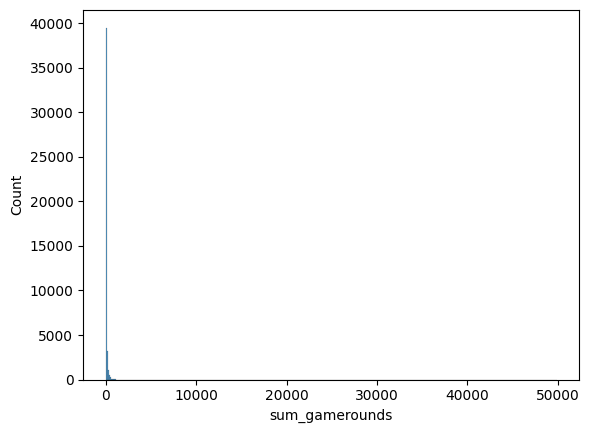

In [21]:
sns.histplot(x=  df[df['version'] == 'gate_30']['sum_gamerounds'])
#большие выбросы

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

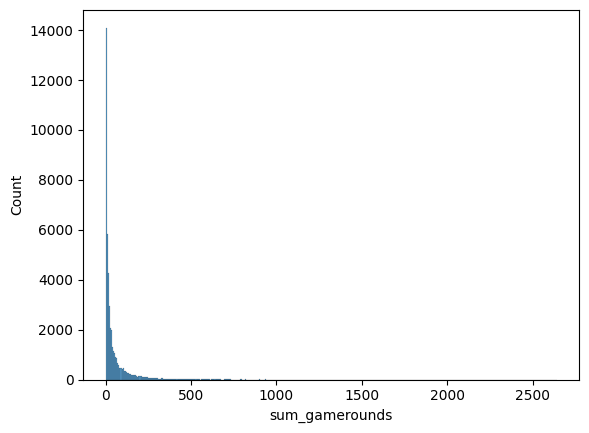

In [52]:
sns.histplot(x=  df[df['version'] == 'gate_40']['sum_gamerounds'])

In [22]:
pg.normality(data = df, dv = 'sum_gamerounds', group = 'version', method = 'normaltest')

,W,pval,normal
version,,,
gate_30,206386.767849,0.0,False
gate_40,52497.051667,0.0,False


In [23]:
st.normaltest(df[df.version == 'gate_30'].sum_gamerounds)

NormaltestResult(statistic=np.float64(206386.7678492216), pvalue=np.float64(0.0))

In [24]:
st.normaltest(df[df.version == 'gate_40'].sum_gamerounds)

NormaltestResult(statistic=np.float64(52497.051667310836), pvalue=np.float64(0.0))

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

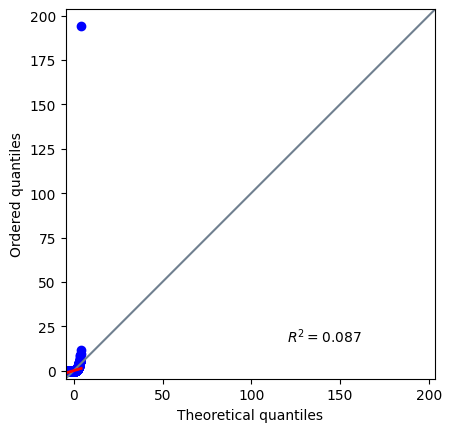

In [25]:
pg.qqplot(df[df.version == 'gate_30'].sum_gamerounds)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

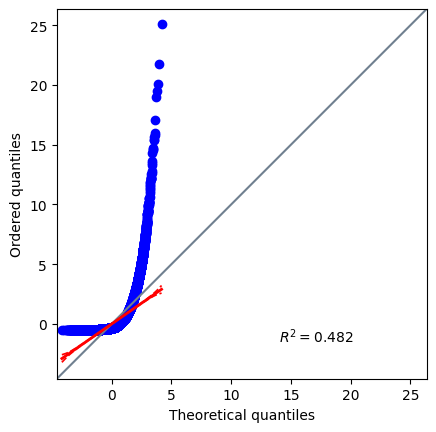

In [26]:
pg.qqplot(df[df.version == 'gate_40'].sum_gamerounds)

In [27]:
#распределение ненормальное - применяем непараметрический тест Манна-Уитни

In [28]:
stat, p = st.mannwhitneyu(df[df.version == 'gate_40'].sum_gamerounds, df[df.version == 'gate_30'].sum_gamerounds)
stat, p

(np.float64(1009027049.5), np.float64(0.05020880772044255))

In [ ]:
#st.bootstrap не проходит по памяти

In [ ]:
#сравним средние

In [46]:
pg.compute_bootci(
    df[df.version == 'gate_40'].sum_gamerounds,
    func=np.mean,
    n_boot=3000,
    confidence=0.95,
    seed=42
)


array([50.38, 52.27])

In [47]:
pg.compute_bootci(
    df[df.version == 'gate_30'].sum_gamerounds,
    func= np.mean,
    n_boot=3000,
    confidence=0.95,
    seed=42
)


array([50.85, 55.86])

In [ ]:
#сравним медианы

In [48]:
pg.compute_bootci(
    df[df.version == 'gate_40'].sum_gamerounds,
    func= np.median,
    n_boot=3000,
    confidence=0.95,
    seed=42
)

array([16., 16.])

In [49]:
pg.compute_bootci(
    df[df.version == 'gate_30'].sum_gamerounds,
    func= np.median,
    n_boot=3000,
    confidence=0.95,
    seed=42
)

array([16., 17.])

In [51]:
#p-value по тесту Манна-Уитни превышает 0,05, по bootstrap-у средних и медиан доверительные интервалы перекрываются. Значит, нет оснований для отклонения нулевой гипотезы.